In [1]:
import pandas as pd
import numpy as np
import math
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.datasets import make_regression
from sklearn.preprocessing import RobustScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import KFold, GridSearchCV

from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn import preprocessing
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
%matplotlib inline
%config InlineBakend.figure_format = 'svg'
from sklearn.svm import SVC
from sklearn.metrics import r2_score
pd.options.display.float_format = '{:,.2f}'.format


In [2]:
data = pd.read_csv("train.csv")
data = pd.DataFrame(data)

In [3]:
data.describe()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,"10,000.00","10,000.00","10,000.00","10,000.00","7,887.00","10,000.00","10,000.00","10,000.00","10,000.00","10,000.00","10,000.00","10,000.00","10,000.00","5,202.00","10,000.00","10,000.00","10,000.00"
mean,"8,383.41",50.40,1.89,56.32,37.20,6.27,8.53,12.61,"3,990.17",0.12,24.69,"5,352.16",8.04,"1,142.90",1.32,4.23,"214,138.86"
std,"4,859.02",43.59,0.84,21.06,86.24,28.56,5.24,6.78,"200,500.26",0.12,17.53,"4,006.80",23.83,"1,021.52",1.49,4.81,"92,872.29"
min,0.00,0.00,0.00,1.14,0.37,0.00,1.00,0.00,"1,910.00",0.00,0.00,168.00,0.00,0.00,0.00,0.00,"59,174.78"
25%,"4,169.50",20.00,1.00,41.77,22.77,1.00,4.00,9.00,"1,974.00",0.02,6.00,"1,564.00",0.00,350.00,0.00,1.00,"153,872.63"
50%,"8,394.50",36.00,2.00,52.51,32.78,6.00,7.00,13.00,"1,977.00",0.08,25.00,"5,285.00",2.00,900.00,1.00,3.00,"192,269.64"
75%,"12,592.50",75.00,2.00,65.90,45.13,9.00,12.00,17.00,"2,001.00",0.20,36.00,"7,227.00",5.00,"1,548.00",2.00,6.00,"249,135.46"
max,"16,798.00",209.00,19.00,641.07,"7,480.59","2,014.00",42.00,117.00,"20,052,011.00",0.52,74.00,"19,083.00",141.00,"4,849.00",6.00,23.00,"633,233.47"


###  Посмотрим  распределение  признаков 

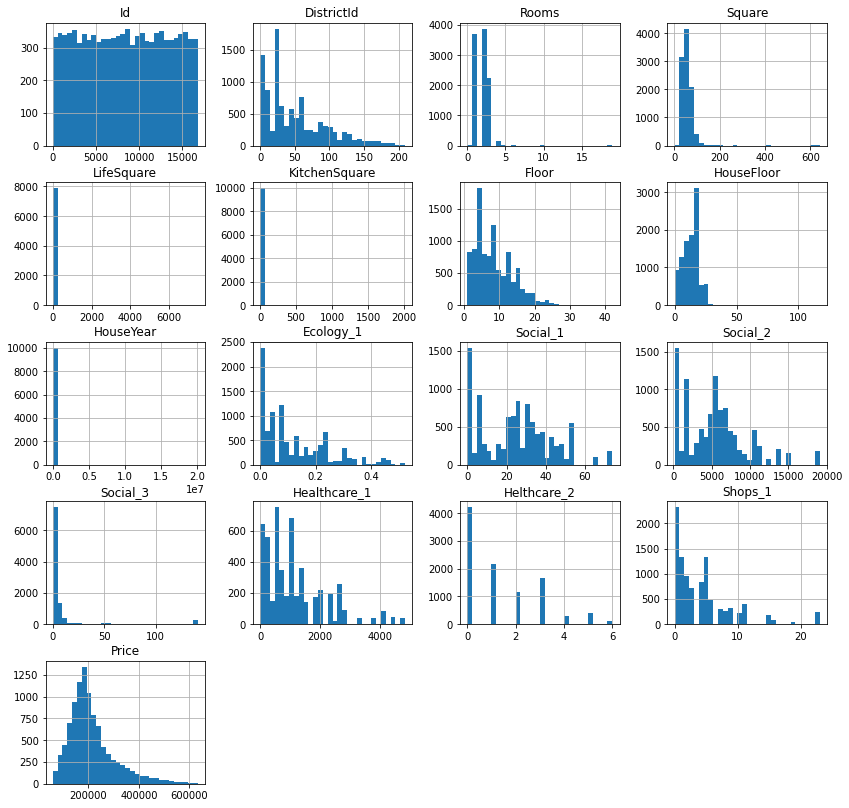

In [4]:
data.hist(figsize=(14,14), bins=30, grid=True);

#### Уберем параметры str (А и B) во всей таблице

In [5]:
data.replace('A', 0, inplace=True)
data.replace('B', 0, inplace=True)

#### Нормализуем выбросы по параметру HouseYear

In [6]:
data.loc[1497, ['HouseYear']] = 2011

In [7]:
data.loc[4189, ['HouseYear']] = 1985 #медиана

#### Нормализуем выбросы по параметру Rooms и LifeSquare

In [8]:
data['Rooms'].value_counts()

2.00     3880
1.00     3705
3.00     2235
4.00      150
5.00       18
0.00        8
10.00       2
19.00       1
6.00        1
Name: Rooms, dtype: int64

In [9]:
data.drop(data.index[1454], inplace=True)

In [10]:
data.loc[(data['Rooms'] > 8)|(data['Rooms'] == 0), 'Rooms'] = data['Rooms'].mode()[0]

In [11]:
data.loc[data['LifeSquare']>300] = data['LifeSquare'].mode()[0]

In [12]:
data.loc[data['KitchenSquare']>100]  = data['LifeSquare'].mode()[0]

In [13]:
data.loc[(data['Square'] < data['LifeSquare'] + data['KitchenSquare']), 'Square'] =\
data['LifeSquare'] + data['KitchenSquare']

In [14]:
data.loc[data['Square']>300] = data['Square'].mode()[0]

#### Добавили новый параметр - стоимость за квадрат

In [15]:
data['Price per meter'] = data['Price']/data['Square']

#### Добавили новый параметр - стоимость по  District

In [16]:
district_size = data['DistrictId'].value_counts().reset_index()\
                .rename(columns={'index':'DistrictId', 'DistrictId':'DistrictSize'})

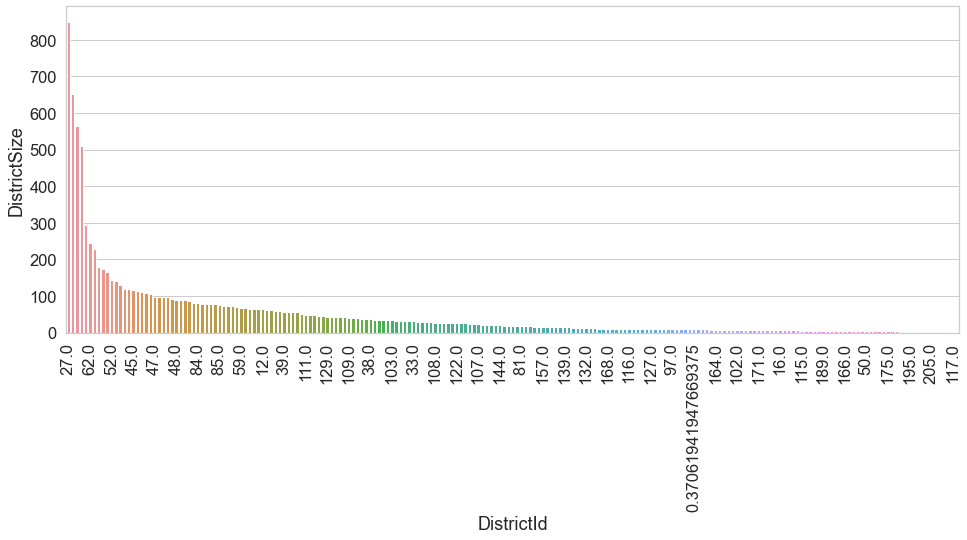

In [17]:
sns.set(style="whitegrid", font_scale=1.5)
f, ax = plt.subplots(figsize=(16,6))
sns.barplot(y='DistrictSize', x='DistrictId', 
            data=district_size,
            order=district_size.sort_values(by='DistrictSize', ascending=False)['DistrictId']
           );
ax.tick_params(axis='x', rotation=90)
ax.xaxis.set_major_locator(plt.MaxNLocator(50))

In [18]:
districts_popular = district_size.loc[district_size['DistrictSize'] > 90, 'DistrictId'].tolist()

In [19]:
district_size.loc[~district_size['DistrictId'].isin(districts_popular), 'DistrictId'] = 999
district_size = district_size.groupby('DistrictId')['DistrictSize'].agg(
                            DistrictSize='median')
district_size.reset_index(level='DistrictId', inplace=True)


In [20]:
data.loc[~data['DistrictId'].isin(districts_popular), 'DistrictId'] = 999

In [21]:
data = data.merge(district_size, on='DistrictId', how='left').set_index(data.index)


In [22]:
price_by_district = data.groupby(['DistrictId'], as_index=False)\
                        .agg({'Price per meter':'median'})\
                        .rename(columns={'Price per meter':'Avg price by Dist (per metr)'})

In [23]:
data = data.merge(price_by_district, on=['DistrictId'], how='left').set_index(data.index)


### Заполним NaN по LifeSquare и Healthcare_1 также используя методы машинного обучения

<AxesSubplot:xlabel='LifeSquare'>

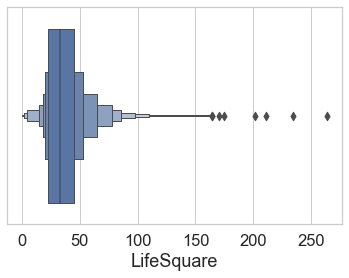

In [24]:
sns.boxenplot(x=data['LifeSquare'], data=data)

In [25]:
outliners_LS = data.dropna()

In [26]:
df = outliners_LS.drop(['LifeSquare'], axis=1)
df.drop(['Healthcare_1'], axis=1, inplace=True)
target_LS = outliners_LS['LifeSquare']

In [27]:
X_train, X_test, y_train, y_test = train_test_split(df, target_LS, test_size=0.25, random_state=42)

In [28]:
gb_LS = GradientBoostingRegressor(n_estimators=1000)

In [29]:
gb_LS.fit(X_train, y_train)

GradientBoostingRegressor(n_estimators=1000)

In [30]:
y_pred_ls_gb = gb_LS.predict(X_test)

In [31]:
r2_score(y_test, y_pred_ls_gb)

0.6011617563334536

In [32]:
y_NaN_LS = data[pd.isna(data['LifeSquare'])]

In [33]:
y_NaN_LS.drop(['Healthcare_1'], axis=1, inplace=True)
y_NaN_LS.drop(['LifeSquare'], axis=1, inplace=True)

c:\program files (x86)\python\lib\site-packages\pandas\core\frame.py:4167: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [34]:
y_pred_NaN_lrs = pd.DataFrame(gb_LS.predict(y_NaN_LS))

In [35]:
y_pred_NaN_lrs.set_index(y_NaN_LS.index, inplace=True),
y_pred_NaN_lrs.rename(columns={0: "LifeSquare"}, inplace=True)

In [36]:
data.loc[data['LifeSquare'].index.isin(y_pred_NaN_lrs.index), ['LifeSquare']] = y_pred_NaN_lrs['LifeSquare']

#### тоже самое сделаем для Healtcare

[]

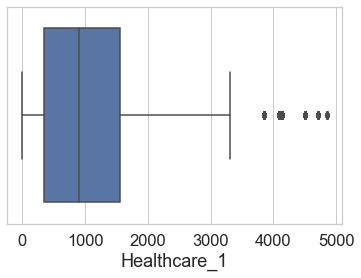

In [37]:
sns.boxplot(x= data['Healthcare_1'], data=data)
plt.plot()

In [38]:
frame_HC  = pd.DataFrame(data)
### видно из таблицы и графика, что данные выбросы класторизированны - и я удалять их не буду.

In [39]:
out_NaN = frame_HC.dropna()

In [40]:
df_HC = out_NaN.drop(['Healthcare_1'], axis=1)
target_HC = out_NaN['Healthcare_1']

In [41]:
X_train_HC, X_test_HC, y_train_HC, y_test_HC = train_test_split(df_HC, target_HC, test_size=0.25, random_state=36)

In [42]:
clf_GB_HC = GradientBoostingRegressor(n_estimators=1000, random_state=50)

In [43]:
clf_GB_HC.fit(X_train_HC, y_train_HC)

GradientBoostingRegressor(n_estimators=1000, random_state=50)

In [44]:
y_pred_GB_HC = clf_GB_HC.predict(X_test_HC)

In [45]:
print(f'R^2 score = {r2_score(y_test_HC, y_pred_GB_HC):.4f}')

R^2 score = 0.9995


In [46]:
y_NaN_HC = data[pd.isna(data["Healthcare_1"])]

In [47]:
y_NaN_HC.drop(['Healthcare_1'], axis=1, inplace=True)

c:\program files (x86)\python\lib\site-packages\pandas\core\frame.py:4167: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [48]:
y_pred_NaN_hc = pd.DataFrame(clf_GB_HC.predict(y_NaN_HC))

In [49]:
y_pred_NaN_hc.set_index(y_NaN_HC.index, inplace=True),
y_pred_NaN_hc.rename(columns={0: "Healthcare_1"}, inplace=True)

In [50]:
data.loc[data['Healthcare_1'].index.isin(y_pred_NaN_hc.index), ['Healthcare_1']] = y_pred_NaN_hc['Healthcare_1']

## Теперь предскажем модель на train 

In [51]:
feature_names = data.columns

In [52]:
feature_names = ['Rooms', 'Square',
       'Floor', 'HouseFloor', 'HouseYear', 'Ecology_2',
       'Ecology_3', 'Social_1', 'Social_2', 'Social_3','Helthcare_2','Shops_1','Shops_2',
       'DistrictSize', 'Avg price by Dist (per metr)']

In [53]:
df_Pr = data[feature_names]
target_Pr = data['Price']

In [54]:
X_train_Price, X_test_Price, y_train_Price, y_test_Price = train_test_split(df_Pr, target_Pr, test_size=0.25, random_state = 62)

In [55]:
clf_GB = GradientBoostingRegressor(n_estimators=1000, random_state=100)

In [56]:
clf_GB.fit(X_train_Price, y_train_Price)

GradientBoostingRegressor(n_estimators=1000, random_state=100)

In [57]:
y_pred_GB = clf_GB.predict(X_test_Price)

In [58]:
print(f'R^2 score = {r2_score(y_test_Price, y_pred_GB):.4f}')

R^2 score = 0.7511


In [59]:
print(f'MAE = {mean_absolute_error(y_test_Price, y_pred_GB):.4f}')

MAE = 28762.8061


**Перекрестная проверка модели**

In [60]:
kf = KFold(n_splits=5, random_state=100, shuffle=True)
cv_score = cross_val_score(clf_GB, X_train_Price, y_train_Price, scoring='r2', cv=kf)
print('R2: {:.5f}'.format(cv_score.mean()))

R2: 0.71301


### Загружает тестовые данные

In [61]:
data_test = pd.DataFrame(pd.read_csv("test.csv"))

#### Добавим такие же новые параметры как для train и нормализуем остальные

In [62]:
district_size.loc[~district_size['DistrictId'].isin(districts_popular), 'DistrictId'] = 999
district_size = district_size.groupby('DistrictId')['DistrictSize'].agg(
                            DistrictSize='median')
district_size.reset_index(level='DistrictId', inplace=True)


In [63]:
data_test.loc[~data_test['DistrictId'].isin(districts_popular), 'DistrictId'] = 999

In [64]:
data_test = data_test.merge(district_size, on='DistrictId', how='left').set_index(data_test.index)


In [65]:
data_test = data_test.merge(price_by_district, on=['DistrictId'], how='left').set_index(data_test.index)

In [66]:
data_test.replace('A', 0, inplace=True)
data_test.replace('B', 0, inplace=True)

In [67]:
data_test.loc[(data_test['Rooms'] > 8)|(data_test['Rooms'] == 0), 'Rooms'] = data_test['Rooms'].mode()[0]

In [68]:
data_test.loc[data_test['KitchenSquare']>100]  = data_test['LifeSquare'].mode()[0]

In [69]:
data_test.loc[(data_test['Square'] < data_test['LifeSquare'] + data_test['KitchenSquare']), 'Square'] = data_test['LifeSquare'] + data_test['KitchenSquare']

#### Так как модели натренерованные на отличных признаках - здесь пропуски будут заменены с помощью медиан и разницы значений смежных признаков

In [70]:
data_test.isna().sum()[data_test.isna().sum() != 0]

LifeSquare      1041
Healthcare_1    2376
dtype: int64

In [71]:
data_test.loc[data_test['LifeSquare'].isna(), 'LifeSquare'] = \
    data_test['Square'] - data_test['KitchenSquare']
data_test.loc[data_test['LifeSquare'].isna(), 'LifeSquare'] = \
    data_test['Square'] - data_test['KitchenSquare']

In [72]:
data_test['Healthcare_1'].fillna(data_test['Healthcare_1'].median(), inplace=True)
data_test['Healthcare_1'].fillna(data_test['Healthcare_1'].median(), inplace=True)

In [78]:
#### Предскажем цену на тестовм сете

In [79]:
y_pred_GB_test = pd.DataFrame(clf_GB.predict(data_test[feature_names]), index=data_test.index)

In [80]:
data_test['Price'] = y_pred_GB_test[0]

In [81]:
finita = data_test[['Id', 'Price']]

In [82]:
finita.to_csv(r'Diploma_finita.csv')